# Gaussian Process on the concrete UCI dataset, using Inducing Points and all points

# Github

In [1]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
from sklearn.model_selection import train_test_split
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/concrete.ipynb # Run the concrete notebook which is in the datasets folder(concrete dataset)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 17.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixtur

# Training/Test data from concrete.ipynb

In [3]:
# Set a seed for reproducibility
np.random.seed(52)

concrete_data = df_Concrete # df_Concrete is defined in ../datasets/concrete.ipynb
x, y = concrete_data.iloc[:, :-1].to_numpy() , concrete_data.iloc[:, -1].to_numpy()  # The last column is output(concrete compressive strength)

# Split into training and validation datasets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1)

# Standardize training input points
xTrain_mean = xTrain.mean(axis = 0) # mean for each feature
xTrain_std = xTrain.std(axis = 0) # std for each feature
xTrain_standardized = (xTrain-xTrain_mean) / xTrain_std # Standardize
# Standardize training output points
yTrain_mean = yTrain.mean(axis = 0) # mean
yTrain_std = yTrain.std(axis = 0) # std
yTrain_standardized = (yTrain-yTrain_mean) / yTrain_std # Standardize
yTrain_standardized_mean = yTrain_standardized.mean(axis = 0) # Mean after standardization

# Standardize test input points
xTest_mean = xTest.mean(axis = 0) # mean for each feature
xTest_std = xTest.std(axis = 0) # std for each feature
xTest_standardized = (xTest-xTest_mean) / xTest_std # Standardize
# Standardize test output points
yTest_mean = yTest.mean(axis = 0) # mean
yTest_std = yTest.std(axis = 0) # std
yTest_standardized = (yTest-yTest_mean) / yTest_std # Standardize
yTest_standardized_mean = yTest_standardized.mean(axis = 0) # Mean after standardization

# Convert them to tensors
xTrain_standardized = torch.from_numpy(xTrain_standardized).float()
yTrain_standardized = torch.from_numpy(yTrain_standardized).float()

xTest_standardized = torch.from_numpy(xTest_standardized).float()
yTest_standardized = torch.from_numpy(yTest_standardized).float()

print(xTrain_standardized.size(), yTrain_standardized.size(), xTest_standardized.size(), yTest_standardized.size())

torch.Size([927, 8]) torch.Size([927]) torch.Size([103, 8]) torch.Size([103])


# The GP model

In [4]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(GPModel, self).__init__(x, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [5]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain_standardized, yTrain_standardized, likelihood) # Use training points and given likelihood
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Training Function

In [12]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain

  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 150


  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()


# Train the Model#

In [27]:
%time train(model, xTrain_standardized, yTrain_standardized)

CPU times: user 9.47 s, sys: 21.7 ms, total: 9.49 s
Wall time: 10.5 s


# The posterior mean, variance and Covariance Matrix

In [35]:
model.eval() # eval mode is for computing predictions through the model posterior
posterior_distribution = model(xTest_standardized) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = posterior_distribution.mean # Predictive mean
f_var = posterior_distribution.variance # Predictive variance
f_covar = posterior_distribution.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([103])

Variance Dimension:  torch.Size([103])

CovMatrix Dimension  torch.Size([103, 103])


# Predictive Distribution

In [37]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(posterior_distribution)# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean = observed_pred.mean.numpy()

# Compute Root Mean Square Error (RMSE)

In [38]:
squared_error = (mean - yTest_standardized.numpy())**2 # Compute the squared error

mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

print(root_MSE)
# To transform the RMSE back to the original scale after normalization,
# you can simply multiply the RMSE by the standard deviation of the original output data and add the mean
print("RMSE: ", (root_MSE * yTest_std) + yTest_standardized_mean)

0.3386492399331641
RMSE:  5.65164101404808


# Check for Overfitting, (RMSE of training data)

In [32]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred_train = likelihood(model(xTrain_standardized))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean_train = observed_pred_train.mean.numpy()

squared_error_train = (mean_train - yTrain_standardized.numpy())**2 # Compute the squared error

mean_SE_train = squared_error_train.mean() # Compute the mean squared error

root_MSE_train = math.sqrt(mean_SE_train) # Compute the square root of the mean squared error

root_MSE_train

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


0.16147743709408013

# Compare different amount of points

In [33]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPoints(listOfPoints):
  timeList = []
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    inducingPointsX = torch.tensor(xTrain_standardized[:points]) # Choose how many points to pick
    inducingPointsY = torch.tensor(yTrain_standardized[:points]) # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print()
    print("Inducing Points: ", points)

    time = %timeit -o train(model, inducingPointsX, inducingPointsY) # Train the model
    timeList.append(time.all_runs) # Add mean time of all runs for current amount of points
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()
  return timeList
timeList = severalInducingPoints([10,50,100,200,300,400,500,600,700,900])


<ipython-input-33-69517dff5db7>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducingPointsX = torch.tensor(xTrain_standardized[:points]) # Choose how many points to pick
<ipython-input-33-69517dff5db7>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducingPointsY = torch.tensor(yTrain_standardized[:points]) # Choose how many points to pick



Inducing Points:  10
The slowest run took 4.68 times longer than the fastest. This could mean that an intermediate result is being cached.
683 ms ± 478 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  50
420 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  100
469 ms ± 7.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  200
942 ms ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  300
1.14 s ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  400
2.03 s ± 391 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  500
3.34 s ± 549 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  600
4.85 s ± 591 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  700
7.31 s ± 1.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  900
9.48 s ± 747 ms per loop (mean ± std. dev. of 7 ru

# Plot The Different Times

([<matplotlib.axis.XTick at 0x7805e3d88910>,
 [Text(1, 0, '100'),
  Text(2, 0, '200'),
  Text(3, 0, '300'),
  Text(4, 0, '400'),
  Text(5, 0, '500'),
  Text(6, 0, '600'),
  Text(7, 0, '700'),
  Text(8, 0, '800'),
  Text(9, 0, '900')])

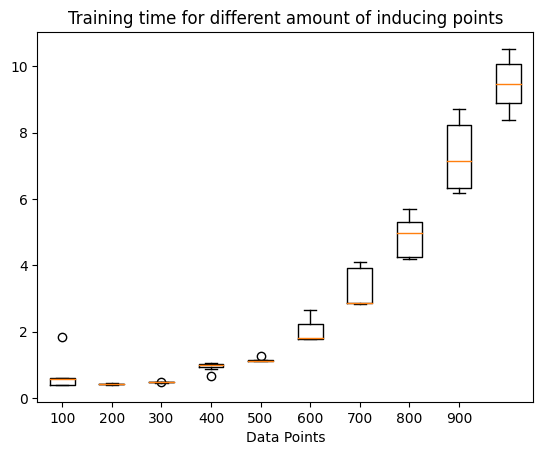

In [34]:
plt.title('Training time for different amount of inducing points')
plt.xlabel('Data Points')

plt.boxplot(timeList)
plt.xticks([1,2,3,4,5,6,7,8,9],[100,200,300,400,500,600,700,800,900])

# Inducing points with K-means

#K-means

In [9]:
# Changing n_init will drastically change execution time
def kmeansPoints(x, y, N): # The dataset (X,Y) and the N amount of inducing points wished
  RS = 0 # Random state
  kmeans = KMeans(n_clusters=N, n_init=1, random_state=RS ).fit(x) # Apply K-means clustering on the normalized training data
  xInducing = kmeans.cluster_centers_ # Use the centers of the clusters as the inducing points
  # To get the corresponding y values for each inducing point, compute the closest data point.
  closest_indices, _ = pairwise_distances_argmin_min(xInducing, x) # Will return indexes of xTrain_KMeans which is most similar(the same in this case) as xInducing
  yInducing = y[closest_indices] # Choose the corresponding y values for the inducing points
  return torch.from_numpy(xInducing).float(), yInducing

# Compare different amount of inducing points
## Speed and performance

In [18]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPointsKmeans(listOfPoints):
  RMSE_list = []
  K_means_times = []
  train_times = []
  posterior_times = []
  for points in listOfPoints:
    start_time = time.time() # Start time
    inducingPointsX, inducingPointsY = kmeansPoints(xTrain_standardized, yTrain_standardized, points) # Calculate Incucing Points
    end_time = time.time() # End time
    execution_time = end_time - start_time # Calculate execution time
    K_means_times.append(execution_time) # Append time


    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    start_time = time.time() # Start time
    train(model, inducingPointsX, inducingPointsY) # Train the model
    end_time = time.time() # End time
    execution_time = end_time - start_time # Calculate execution time
    train_times.append(execution_time) # Append average time
    # Performance
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
      start_time = time.time() # Start time
      observed_pred =  likelihood(model(xTest_standardized))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
      end_time = time.time() # End time
      execution_time = end_time - start_time # Calculate execution time
      posterior_times.append(execution_time) # Append average time
      mean = observed_pred.mean.numpy()


    squared_error = (mean - yTest_standardized.numpy())**2 # Compute the squared error
    mean_SE = squared_error.mean() # Compute the mean squared error
    root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error
    RMSE = (root_MSE * yTest_std) + yTest_standardized_mean # Transform to original scale
    RMSE_list.append(RMSE) # Append to list of RMSE to plot later

  return RMSE_list, K_means_times, train_times, posterior_times # Return all lists for plotting

# Plot Training Times and Performance for different set of Inducing Points

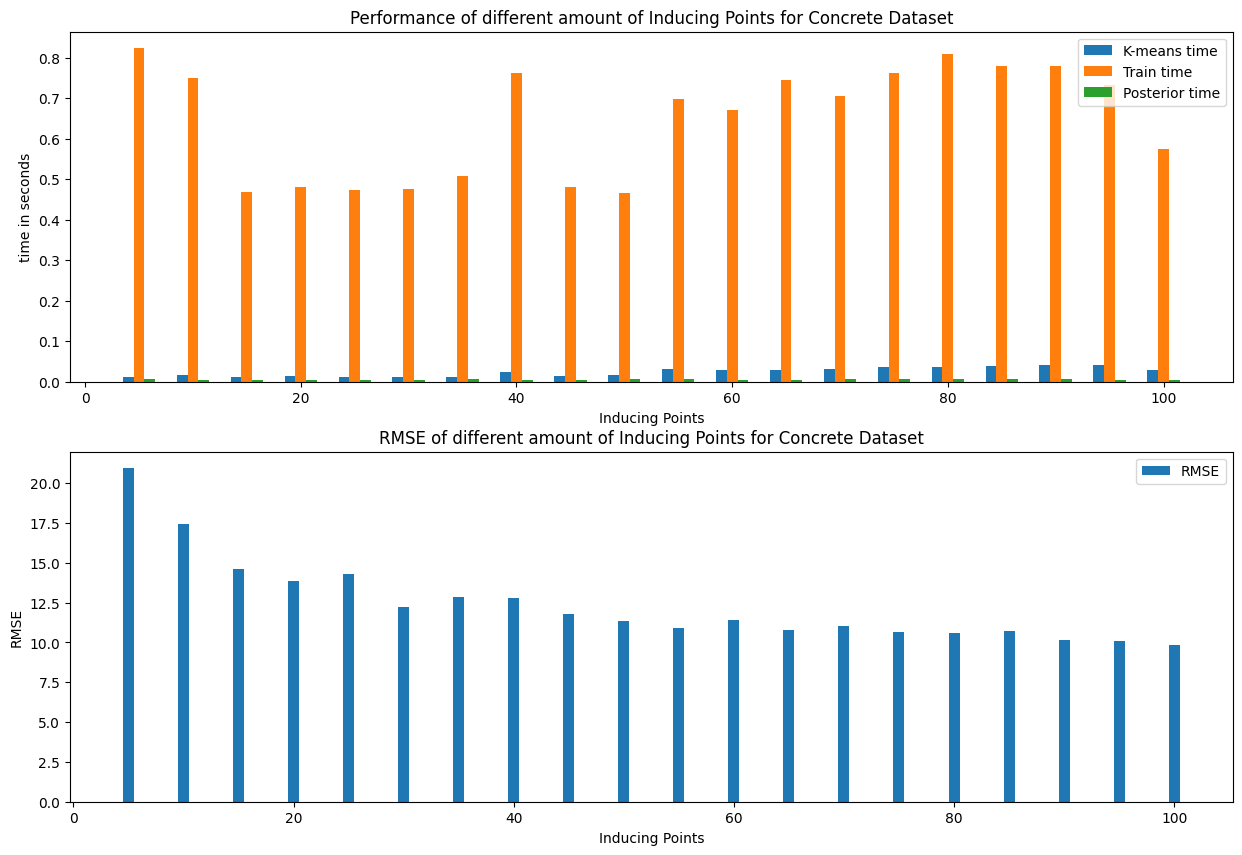

In [52]:
# Get Values
input1 = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
RMSE_list1, K_means_times1, train_times1, posterior_times1 = severalInducingPointsKmeans(input1)

# PLOT

indices = np.array(input1)

# Width of a bar
width = 1

fig, axs = plt.subplots(2, 1, figsize=(15, 10))  # Create a figure and a 1x2 subplot

# First subplot
axs[0].bar(indices - width, K_means_times1, width, label='K-means time')
axs[0].bar(indices, train_times1, width, label='Train time')
axs[0].bar(indices + width, posterior_times1, width, label='Posterior time')

# Adding labels
axs[0].set_xlabel('Inducing Points')
axs[0].set_ylabel('time in seconds')
axs[0].set_title('Performance of different amount of Inducing Points for Concrete Dataset')

# Adding legend
axs[0].legend()

# Second subplot
axs[1].bar(indices, RMSE_list1, width, label='RMSE')

# Adding labels
axs[1].set_xlabel('Inducing Points')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE of different amount of Inducing Points for Concrete Dataset')

# Adding legend
axs[1].legend()

# Function to show the plot
plt.show()

# Larger sets of Inducing Points

<ipython-input-9-ea370ef6be4d>:4: ConvergenceWarning: Number of distinct clusters (896) found smaller than n_clusters (900). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=N, n_init=1, random_state=RS ).fit(x) # Apply K-means clustering on the normalized training data


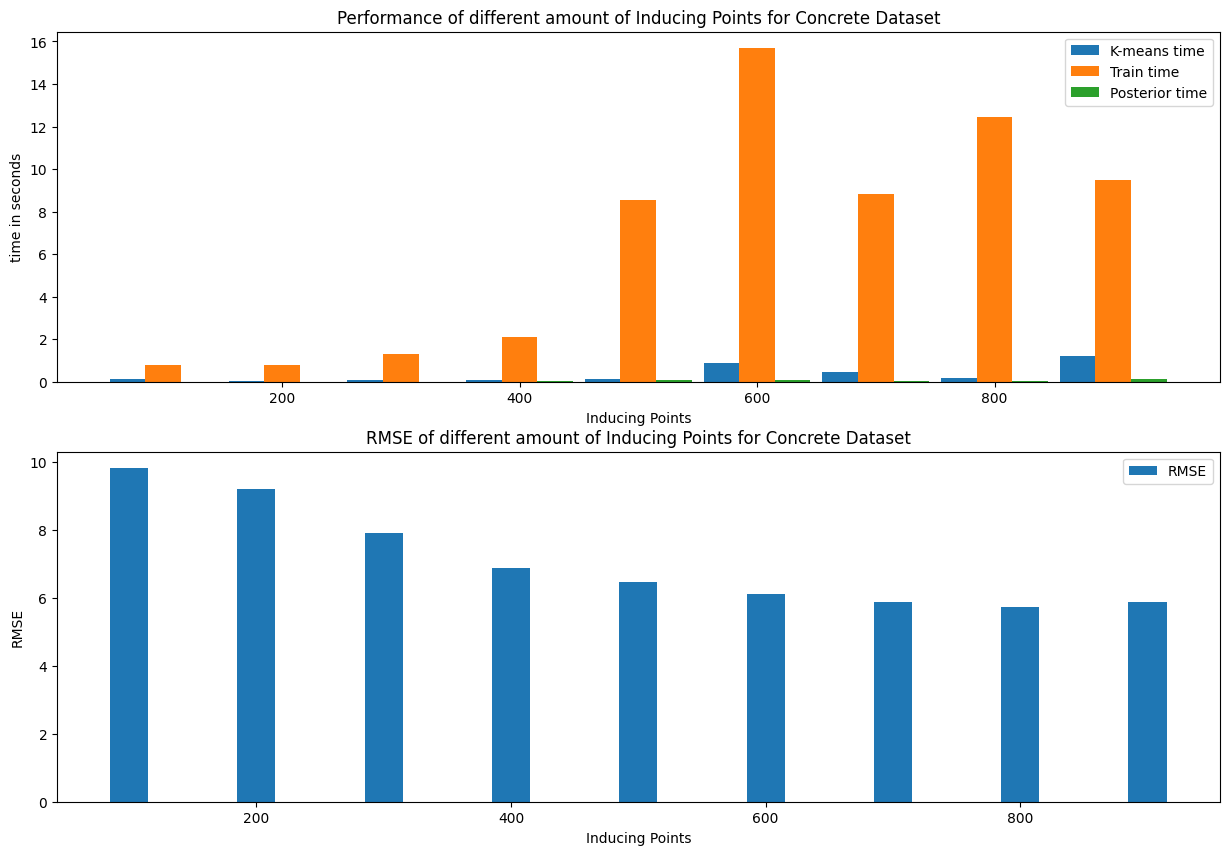

In [49]:
# Get Values
input2 = [100, 200, 300, 400, 500,600, 700, 800, 900]
RMSE_list2, K_means_times2, train_times2, posterior_times2 = severalInducingPointsKmeans(input2)

# PLOT

indices2 = np.array(input2)

# Width of a bar
width = 30

fig, axs = plt.subplots(2, 1, figsize=(15, 10))  # Create a figure and a 1x2 subplot

# First subplot
axs[0].bar(indices2-width, K_means_times2, width, label='K-means time')
axs[0].bar(indices2, train_times2, width, label='Train time')
axs[0].bar(indices2+width, posterior_times2, width, label='Posterior time')

# Adding labels
axs[0].set_xlabel('Inducing Points')
axs[0].set_ylabel('time in seconds')
axs[0].set_title('Performance of different amount of Inducing Points for Concrete Dataset')

# Adding legend
axs[0].legend()

# Second subplot
axs[1].bar(indices2, RMSE_list2, width, label='RMSE')

# Adding labels
axs[1].set_xlabel('Inducing Points')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE of different amount of Inducing Points for Concrete Dataset')

# Adding legend
axs[1].legend()

# Function to show the plot
plt.show()

In [54]:
!git add GPC

/bin/bash: line 1: cd: GPs: No such file or directory
